# Hydrogen algorithm for QAL Quantum Inspire hybrid computing workshop 

Make a new empty Python file

In [2]:
from pathlib import Path

filename = str(Path.cwd() / "hydrogen_algorithm.py") 
!touch {filename}

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Add an `execute` and a `finalize` function to the file with the following input arguments

In [ ]:
from typing import Any
from quantuminspire.util.api.quantum_interface import QuantumInterface


def execute(qi: QuantumInterface) -> None:
    ...

def finalize(results: Any) -> dict[str, Any]:
    ...

Have the `execute` function add something to the results, and have `finalize` return them

In [ ]:
from typing import Any
from quantuminspire.util.api.quantum_interface import QuantumInterface


def execute(qi: QuantumInterface) -> None:
    qi.results = {"results": 2}

def finalize(results: Any) -> dict[str, Any]:
    return results

Use the `print_output` function to execute the Python file and print its output

In [35]:
def print_output():
    output = !poetry run qi files run {filename}
    print(output)
    
print_output()

['/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)', "/home/haroldmeerwaldt/.cache/pypoetry/virtualenvs/quantuminspire-3d1CX1g5-py3.10/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\\x00\\xd0\\xcc\\xcc\\xcc\\xcc\\xcc\\xcc\\xfb\\xbf\\x00\\x00\\x00\\x00\\x00\\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.", 'This warnings indicates broken support for the dtype!', '  machar = _get_machar(dtype)', "{'results': [{'distance': 0.3, 'total_energy': 1.4865802864000002, 'circuit': '   ┌─────────┐┌─────────┐\\nq: ┤ Ry(t_0) ├┤ Rz(t_1) ├\\n   └─────────┘└─────────┘', 'circuit_depth': 2, 'optimal_t_0': -4.450434622822838, 'optimal_t_1': 4.4214434387828305}, {'distance': 0.4, 'total_energy': 1.3952086523, 'circuit': '   ┌─────────┐┌─────────┐\\nq: ┤ Ry(t_0) ├┤ Rz(t_1) ├\\n   └─────────┘└─────────┘', 'circuit_depth': 2, 'optimal_t_0': 6.192765932878906, 'optimal_t_1': -3.7698206453031

In the next couple of cells, we will be adding the hydrogen algorithm to the `execute` function. Add these commands to the function.

Specify a molecule configuration with the distance between the atoms. Make a molecule driver from this, and use it to generate an ElectronicStructureProblem.

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver

distance = 0.735
molecule = f"H 0.0 0.0 0.0; H 0.0 0.0 {distance}"
driver = PySCFDriver(molecule)
es_problem = driver.run()

Get the fermionic (electronic creation and annihilation) operators and store some useful attributes for later 

In [ ]:
fermionic_op = es_problem.hamiltonian.second_q_op()
n_particles = es_problem.num_particles
n_spatial_orbitals = es_problem.num_spatial_orbitals
nuclear_repulsion_energy = es_problem.nuclear_repulsion_energy

Map the fermionic operators onto qubit operators

In [ ]:
from qiskit_nature.second_q.mappers import ParityMapper

mapper = ParityMapper(num_particles=(1, 1))
qubit_op = mapper.map(fermionic_op)

Make the ansatz from the initial state

In [ ]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

initial_state = HartreeFock(n_spatial_orbitals, n_particles, mapper)
ansatz = UCCSD(n_spatial_orbitals, n_particles, mapper, initial_state=initial_state)

Use Quantum Inspire's Qiskit backend to make the estimator

In [ ]:
from qiskit.primitives import BackendEstimator
from quantuminspire.sdk.qiskit.backend import QuantumInspireBackend

backend = QuantumInspireBackend(qi)  # qi is passed into `execute`
estimator = BackendEstimator(backend=backend)

Make the optimizer

In [ ]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=1)

Put everything together to make the VQE algorithm, and run it to get the result

In [ ]:
from qiskit_algorithms import VQE

algo = VQE(estimator, ansatz, optimizer)
result = algo.compute_minimum_eigenvalue(qubit_op)

Replace the returned result with the distance and the total energy. The total energy is the sum of the eigenvalue calculated by the algorithm and the nuclear repulsion energy. 

In [ ]:
qi.results = {"results": [{"distance": distance, "total_energy": result.eigenvalue + nuclear_repulsion_energy}]}

Print the output to show the distance and the total energy

In [5]:
print_output()

['/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)', "/home/haroldmeerwaldt/.cache/pypoetry/virtualenvs/quantuminspire-3d1CX1g5-py3.10/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\\x00\\xd0\\xcc\\xcc\\xcc\\xcc\\xcc\\xcc\\xfb\\xbf\\x00\\x00\\x00\\x00\\x00\\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.", 'This warnings indicates broken support for the dtype!', '  machar = _get_machar(dtype)', "{'results': [{'distance': 0.735, 'total_energy': -0.3868728641492053}]}"]


Now that we can calculate the total energy for a single distance, let's vary the distance and see what happens.

Wrap the entire body of the execute function in a for loop to loop over different distances, replacing the constant `distance`.

In [ ]:
import numpy as np

def execute(qi: QuantumInterface) -> None:
    distances = np.arange(0.3, 2.5, 0.1)
    results = []
    for distance in distances:
        ...  # execute body
        result_dict = {"distance": distance, "total_energy": result.eigenvalue + nuclear_repulsion_energy}
        results.append(result_dict)
    
    qi.results = {"results": results}

Print the output to see the total energy for different distances

In [6]:
print_output()

['/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)', "/home/haroldmeerwaldt/.cache/pypoetry/virtualenvs/quantuminspire-3d1CX1g5-py3.10/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\\x00\\xd0\\xcc\\xcc\\xcc\\xcc\\xcc\\xcc\\xfb\\xbf\\x00\\x00\\x00\\x00\\x00\\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.", 'This warnings indicates broken support for the dtype!', '  machar = _get_machar(dtype)', "{'results': [{'distance': 0.3, 'total_energy': 0.6049237873477202}, {'distance': 0.4, 'total_energy': 0.6523093348834752}, {'distance': 0.5, 'total_energy': -0.15221424567877828}, {'distance': 0.6000000000000001, 'total_energy': -0.3696204820149024}, {'distance': 0.7000000000000002, 'total_energy': -0.332406898702278}, {'distance': 0.8000000000000003, 'total_energy': -0.01777283326791712}, {'distance': 0.9000000000000001, 'total_energy': -0.6504477889180644}, {'distance': 1.0000

For a visual representation, you can plot the total energy vs the distance

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Distance (Angstrom)', ylabel='Potential energy (a.u.)'>)

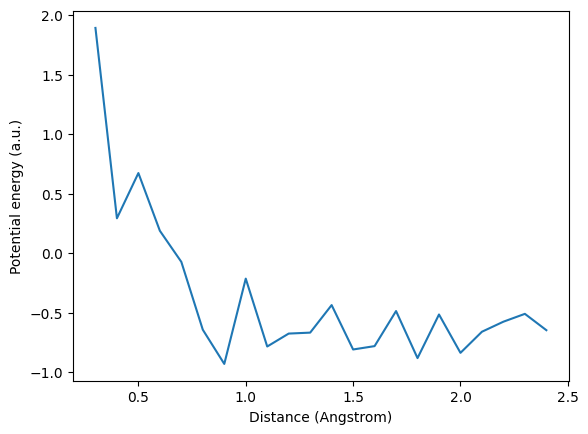

In [9]:
from json import loads
import matplotlib.pyplot as plt

def plot_output():
    output = !poetry run qi files run {filename}
    results = loads(output[-1].replace("'", '"'))["results"]
    distances, energies = [[result[key] for result in results] for key in ["distance", "total_energy"]]
    fig, ax = plt.subplots()
    ax.plot(distances, energies)
    ax.set_xlabel("Distance (Angstrom)")
    ax.set_ylabel("Potential energy (a.u.)")
    return fig, ax

plot_output()

You can see a decreasing function in energy, the atoms start repelling each other at low distances, but it is noisy and there is no clear minimal distance.

Let's try again with more iterations for the optimizer

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Distance (Angstrom)', ylabel='Potential energy (a.u.)'>)

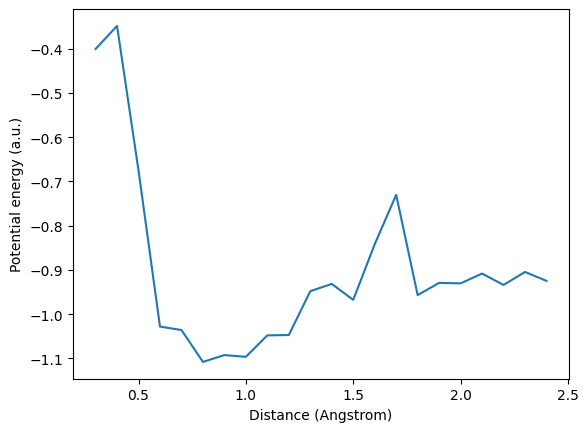

In [10]:
# optimizer = COBYLA(maxiter=10)  # replace in file
plot_output()

And then some more iterations (this may take some minutes)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Distance (Angstrom)', ylabel='Potential energy (a.u.)'>)

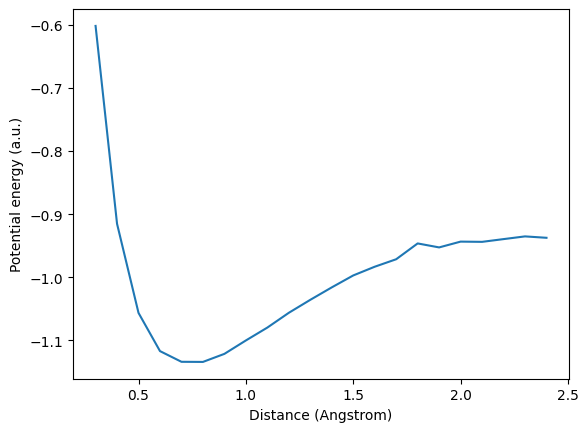

In [11]:
# optimizer = COBYLA(maxiter=100)  # replace in file
plot_output()

Other optimizers are available in `qiskit_algorithms.optimizers` (https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html). Finding the best one depends on the problem.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Distance (Angstrom)', ylabel='Potential energy (a.u.)'>)

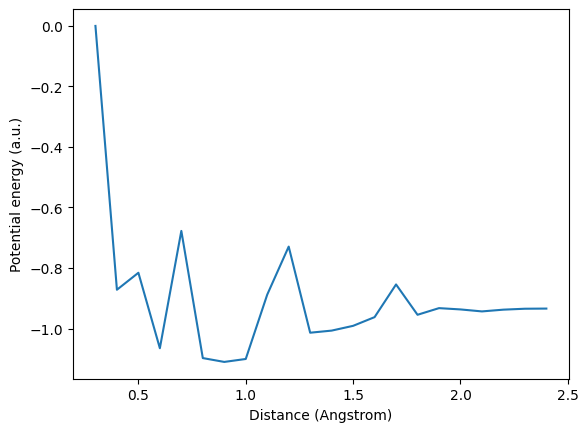

In [18]:
# from qiskit_algorithms.optimizers import NELDER_MEAD
# 
# optimizer = NELDER_MEAD(maxiter=10)  # replace in file

plot_output()

You can print the circuit that is executed. First we add the circuit to the results, in the file, next we print it with the `print_circuit` function. 

In [ ]:
from qiskit import transpile

transpiled_circuit = transpile(result.optimal_circuit, basis_gates=['ry', 'h', 'cx', 'x', 'sdg', 'rz', 's'])
result_dict["circuit"] = repr(transpiled_circuit.draw()).replace("'", '"')
result_dict["circuit_depth"] = transpiled_circuit.depth()


In [28]:
from json import loads

def print_circuit(index: int = 0):
    output = !poetry run qi files run {filename}
    results = loads(output[-1].replace("'", '"'))["results"]
    circuits, circuit_depths = [[result[key] for result in results] for key in ["circuit", "circuit_depth"]]
    print(circuits[index])
    print(f"circuit_depth={circuit_depths[index]}")
    
print_circuit()

global phase: 3π/2
     ┌─────────┐┌──────────┐┌───┐┌──────────────┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐»
q_0: ┤ Rz(π/2) ├┤ Ry(-π/2) ├┤ X ├┤ Rz(1.0*t[0]) ├┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├»
     └──┬───┬──┘└──────────┘└─┬─┘└──────────────┘└─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘»
q_1: ───┤ H ├─────────────────■────────────────────■──┤ H ├┤ Sdg ├┤ H ├──■──»
     ┌──┴───┴──┐┌──────────┐┌───┐┌──────────────┐┌───┐├───┤└┬───┬┘├───┤┌───┐»
q_2: ┤ Rz(π/2) ├┤ Ry(-π/2) ├┤ X ├┤ Rz(1.0*t[1]) ├┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├»
     └──┬───┬──┘└──────────┘└─┬─┘└──────────────┘└─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘»
q_3: ───┤ H ├─────────────────■────────────────────■──┤ H ├┤ Sdg ├┤ H ├──■──»
        └───┘                                         └───┘└─────┘└───┘     »
«     ┌───────────────┐┌───┐┌───┐┌─────┐┌───┐          ┌───┐┌────────────────┐»
«q_0: ┤ Rz(-1.0*t[0]) ├┤ X ├┤ H ├┤ Sdg ├┤ H ├──────────┤ X ├┤ Rz(-0.25*t[2]) ├»
«     └───────────────┘└─┬─┘├───┤└┬───┬┘├───┤     ┌───┐└─┬─┘└────────────────┘»
«q_1: ───────────────────■──┤ H ├─┤ S ├

We can use a different encoding, e.g. the Jordan-Wigner encoding, instead of the parity encoding.

In [25]:
# from qiskit_nature.second_q.mappers import JordanWignerMapper
# 
# mapper = JordanWignerMapper()  # replace in file

print_circuit()

global phase: 3π/2
     ┌─────────┐┌──────────┐┌───┐┌──────────────┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐»
q_0: ┤ Rz(π/2) ├┤ Ry(-π/2) ├┤ X ├┤ Rz(1.0*t[0]) ├┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├»
     └──┬───┬──┘└──────────┘└─┬─┘└──────────────┘└─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘»
q_1: ───┤ H ├─────────────────■────────────────────■──┤ H ├┤ Sdg ├┤ H ├──■──»
     ┌──┴───┴──┐┌──────────┐┌───┐┌──────────────┐┌───┐├───┤└┬───┬┘├───┤┌───┐»
q_2: ┤ Rz(π/2) ├┤ Ry(-π/2) ├┤ X ├┤ Rz(1.0*t[1]) ├┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├»
     └──┬───┬──┘└──────────┘└─┬─┘└──────────────┘└─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘»
q_3: ───┤ H ├─────────────────■────────────────────■──┤ H ├┤ Sdg ├┤ H ├──■──»
        └───┘                                         └───┘└─────┘└───┘     »
«     ┌───────────────┐┌───┐┌───┐┌─────┐┌───┐          ┌───┐┌────────────────┐»
«q_0: ┤ Rz(-1.0*t[0]) ├┤ X ├┤ H ├┤ Sdg ├┤ H ├──────────┤ X ├┤ Rz(-0.25*t[2]) ├»
«     └───────────────┘└─┬─┘├───┤└┬───┬┘├───┤     ┌───┐└─┬─┘└────────────────┘»
«q_1: ───────────────────■──┤ H ├─┤ S ├

Instead of the hydrogen molecule, the VQE algorithm can also be used for different optimization problems. For this, we will replace the `qubit_op` (what we will measure), and the `ansatz` (how we will change the state to be measured). We will measure the operator `X + distance * Z` on one qubit. We have two parameters to optimize, which perform a rotation around the y-axis and then around the z-axis.

In [ ]:
# replace in the file
from qiskit.quantum_info import SparsePauliOp

qubit_op = SparsePauliOp(["X", "Z"], coeffs=np.array([1, distance]))  # 3-qubit bitstrings could be ["XXY", "ZYX"]
nuclear_repulsion_energy = 0

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

params = [Parameter("t_0"), Parameter("t_1")]
ansatz = QuantumCircuit(1)  # 1 = number of qubits
ansatz.ry(params[0], qubit=0)
ansatz.rz(params[1], qubit=0)

# add to the file
result_dict["optimal_t_0"] = result.optimal_parameters[params[0]]
result_dict["optimal_t_1"] = result.optimal_parameters[params[1]]

Next we will plot the optimal parameters and the calculated "energy"

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Distance (Angstrom)'>)

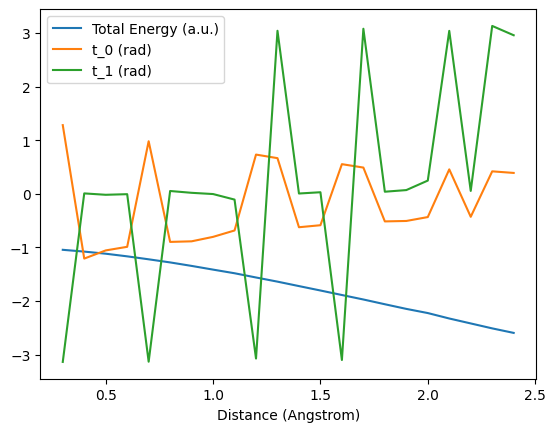

In [49]:
from json import loads
import matplotlib.pyplot as plt
import numpy as np


def plot_outputs():
    output = !poetry run qi files run {filename}
    results = loads(output[-1].replace("'", '"'))["results"]
    keys = ["distance", "total_energy", "optimal_t_0", "optimal_t_1"]
    distances, energies, optimal_t_0s, optimal_t_1s = [[result[key] for result in results] for key in keys]
    fig, ax = plt.subplots()
    ax.plot(distances, energies, label="Total Energy (a.u.)")
    ax.plot(distances, np.mod(optimal_t_0s, 2*np.pi) - np.pi, label="t_0 (rad)")
    ax.plot(distances, np.mod(optimal_t_1s, 2*np.pi) - np.pi, label="t_1 (rad)")
    ax.set_xlabel("Distance (Angstrom)")
    ax.legend()
    return fig, ax

plot_outputs()

Does it make sense what you see as optimization results?

Can you make an optimization problem with two qubits? With three parameters? With more Pauli strings?

What else can you think of?